# EDA
This notebook contains an exploratory data analysis on the [Brist1d](https://www.kaggle.com/competitions/brist1d/data) dataset, from the respective Kaggle competition

In [1]:
# import requiered libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

#import custom functions
from ms_custom_functions import *

#Get Pretty print
from prettyprinter import pprint

from IPython.display import display_html

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
!git branch -a

  QC
  feature/extraxt-patient-data
  feature/ralf-add-interactive-timeseries-for-each-patient
  main
* ms/eda
  update/extract-patient-data
  remotes/origin/HEAD -> origin/main
  remotes/origin/br1_sg
  remotes/origin/feature/extraxt-patient-data
  remotes/origin/feature/ralf-add-interactive-timeseries-for-each-patient
  remotes/origin/main
  remotes/origin/ralf/add-data-overview
  remotes/origin/update/extract-patient-data


In [36]:
# Read raw train data
train = pd.read_csv( '../data/raw/train.csv' , index_col = 0 )
train.head()

,p_num,time,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,bg-5:20,...,activity-0:40,activity-0:35,activity-0:30,activity-0:25,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00,bg+1:00
id,,,,,,,,,,,,,,,,,,,,,
p01_0,p01,06:10:00,NaN,NaN,9.6,NaN,NaN,9.7,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.4
p01_1,p01,06:25:00,NaN,NaN,9.7,NaN,NaN,9.2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.8
p01_2,p01,06:40:00,NaN,NaN,9.2,NaN,NaN,8.7,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.5
p01_3,p01,06:55:00,NaN,NaN,8.7,NaN,NaN,8.4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.8
p01_4,p01,07:10:00,NaN,NaN,8.4,NaN,NaN,8.1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.7


In [37]:
# Read the 'all_train.csv' file, to get a table of time resolution
all_train = pd.read_csv( '../data/interim/all_train.csv' ,  parse_dates = [0] ,  index_col = 0 )
time_res = all_train[['p_num','initial_resolution']].drop_duplicates()
time_res_d = dict( zip( time_res.p_num , time_res.initial_resolution ) )
pprint( time_res_d )

#Add the time resolution to the raw data
train['initial_resolution'] = train['p_num'].map( time_res_d )

{
    'p01': '15min',
    'p02': '5min',
    'p03': '5min',
    'p04': '5min',
    'p05': '15min',
    'p06': '15min',
    'p10': '5min',
    'p11': '5min',
    'p12': '5min'
}


# Distribution of bg+1:00 values
The first thing to look at would be the distribution of bg-+1:00

count    177024.000000
mean          8.277045
std           2.996398
min           2.200000
25%           6.100000
50%           7.700000
75%           9.900000
max          27.800000
Name: bg+1:00, dtype: float64

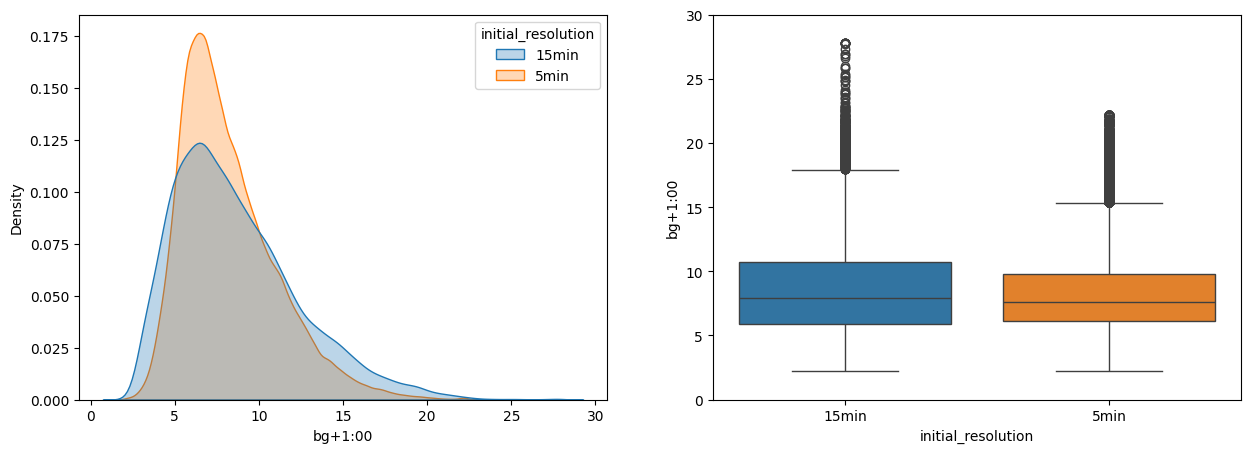

In [6]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax = ax.flatten()

sns.kdeplot( data = train , x = 'bg+1:00' , hue = 'initial_resolution' , ax = ax[0] , common_norm = False , fill = True , alpha = .3 )
sns.boxplot( data = train , x = 'initial_resolution' , y = 'bg+1:00' , hue = 'initial_resolution' , ax = ax[1] )

#ax[1].set_yscale('log')
ax[1].set_yticks( np.arange(0,31,5) ) 

display( train['bg+1:00'].describe() )

<Axes: xlabel='variable', ylabel='value'>

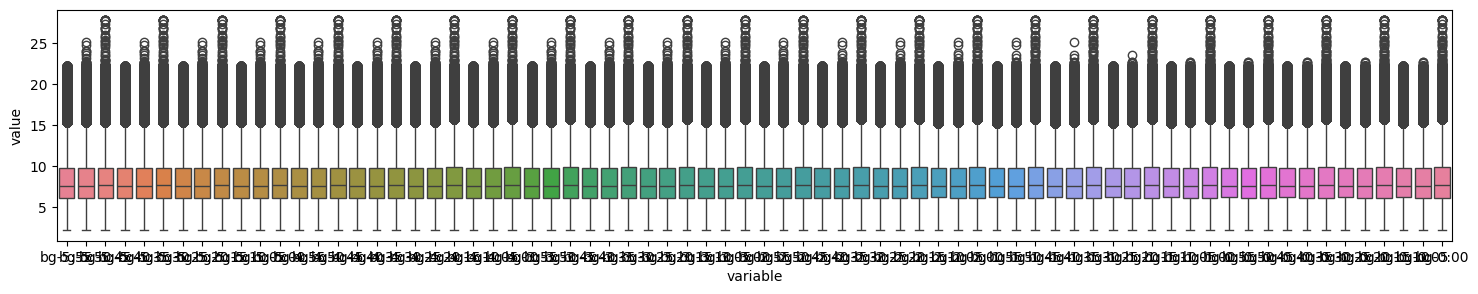

In [71]:
plt.figure( figsize=(18,3) )
sns.boxplot( 
    data = train.filter( like = 'bg-' ).melt() , 
    x = 'variable' , 
    y = 'value' , 
    hue = 'variable'
    )


# what is the correlation among numerical variables in the data ?

<Axes: >

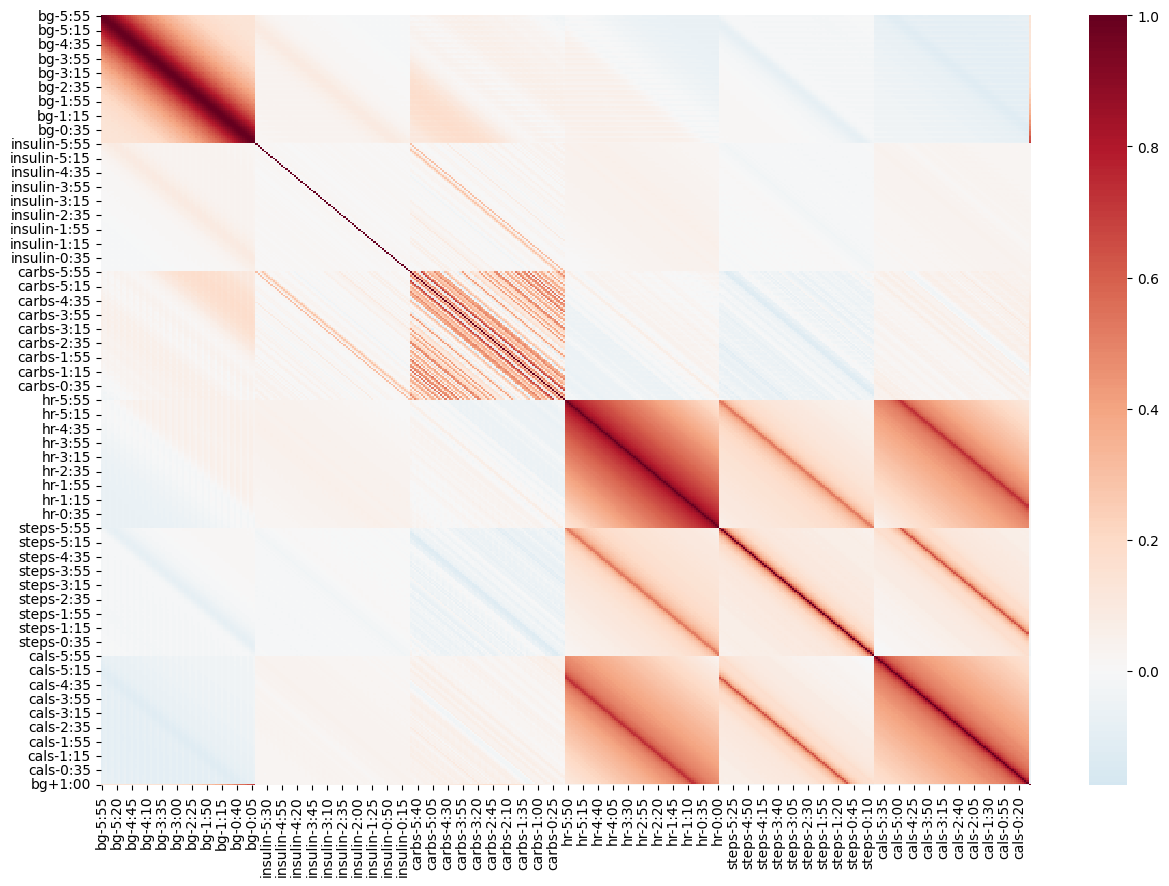

In [25]:
plt.figure( figsize=(15,10) )
corr_df = train.select_dtypes( include = np.number ).corr()
sns.heatmap( corr_df , center = 0 , cmap = "RdBu_r" )

<Axes: >

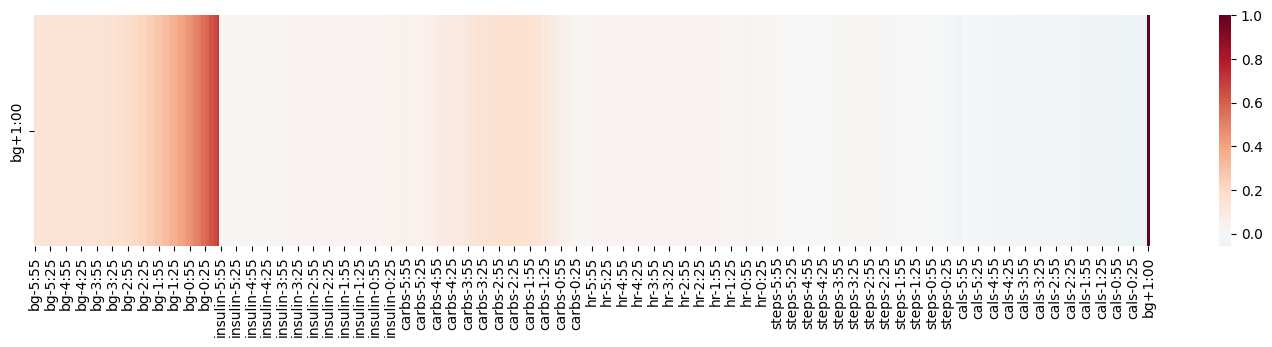

In [10]:
plt.figure( figsize=(18,3) )
sns.heatmap( pd.DataFrame( corr_df.loc[:,'bg+1:00'] ).T , center = 0 , cmap = "RdBu_r" )

<Figure size 1500x1000 with 0 Axes>

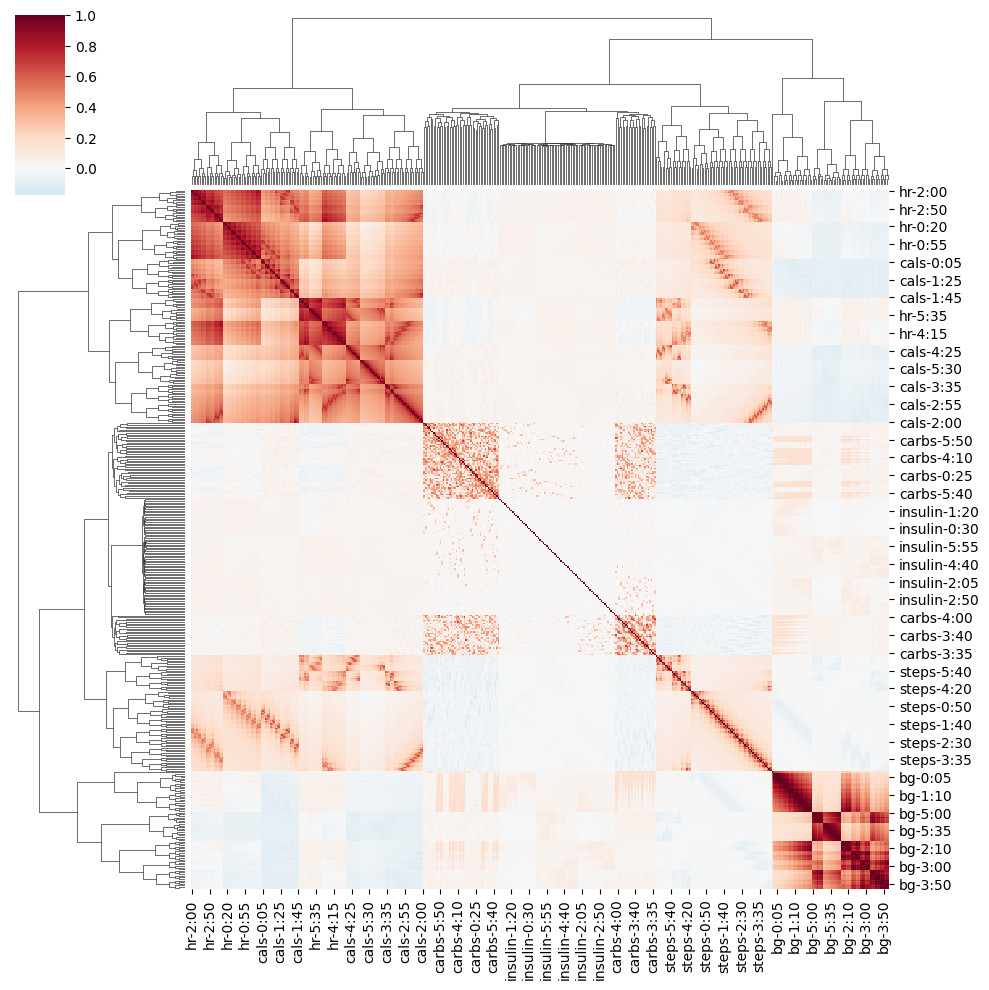

In [8]:
plt.figure( figsize=(15,10) )
sns.clustermap( corr_df , center = 0 , cmap = "RdBu_r" )

In [9]:
# corr_df = train.select_dtypes( include = np.number ).corr()
bg_plus_1_corr = pd.DataFrame( corr_df.loc[:,'bg+1:00'] ).sort_values( 'bg+1:00' , ascending = False ).reset_index()
bg_plus_1_corr.columns = ['column','bg+1h_corr']
bg_plus_1_corr[['metric','time']] = bg_plus_1_corr['column'].str.split('-',expand=True)
bg_plus_1_corr.groupby('metric').agg({'bg+1h_corr':np.mean})

html1 = bg_plus_1_corr.head( 10 ).to_html()
html2 = bg_plus_1_corr.iloc[30:40].to_html()
html3 = bg_plus_1_corr.tail( 10 ).to_html()

display_html(
    f'<div style="display:inline-block; padding-right:10px;">{html1}</div>'
    f'<div style="display:inline-block; padding-right:10px;">{html2}</div>'
    f'<div style="display:inline-block">{html3}</div>',
    raw = True 
)


,column,bg+1h_corr,metric,time
0,bg+1:00,1.000000,bg+1:00,None
1,bg-0:00,0.700750,bg,0:00
2,bg-0:05,0.658533,bg,0:05
3,bg-0:10,0.631411,bg,0:10
4,bg-0:15,0.624325,bg,0:15
5,bg-0:20,0.583130,bg,0:20
6,bg-0:25,0.559578,bg,0:25
7,bg-0:30,0.557125,bg,0:30
8,bg-0:35,0.517450,bg,0:35
9,bg-0:45,0.497884,bg,0:45


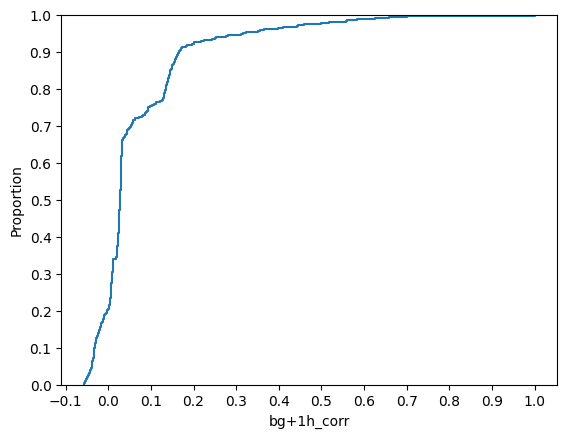

In [10]:
sns.ecdfplot(data=bg_plus_1_corr, x="bg+1h_corr")
plt.xticks( np.arange(-0.1,1.01,.1) )
plt.yticks( np.arange(0,1.01,.1) );

# Let's make example scatterplots for high-, mid- or low- correlataed features to bg+1:00

<Axes: xlabel='cals-0:45', ylabel='bg+1:00'>

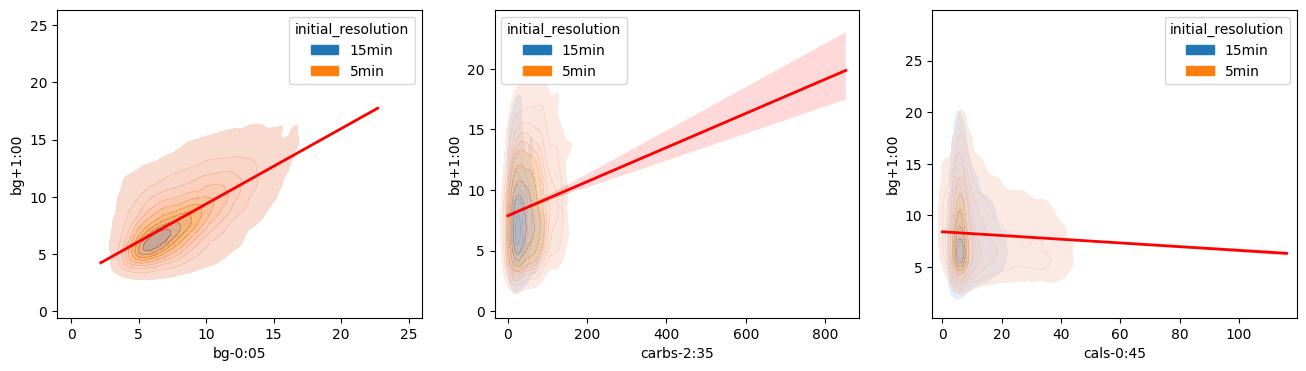

In [15]:
fig,ax = plt.subplots(1,3,figsize=(16,4))
ax = ax.flatten()

sns.kdeplot( data = train , y = 'bg+1:00' , x = 'bg-0:05' , hue = 'initial_resolution' , fill = True , alpha = .5, ax = ax[0] )
sns.regplot( data = train , y = 'bg+1:00' , x = 'bg-0:05' , scatter = False , color = 'red' , line_kws={'linewidth': 2} , ax = ax[0] )

sns.kdeplot( data = train , y = 'bg+1:00' , x = 'carbs-2:35' , hue = 'initial_resolution' , fill = True , alpha = .3 , ax = ax[1] )
sns.regplot( data = train , y = 'bg+1:00' , x = 'carbs-2:35' , scatter = False , color = 'red' , line_kws={'linewidth': 2} , ax = ax[1] )

sns.kdeplot( data = train , y = 'bg+1:00' , x = 'cals-0:45' , hue = 'initial_resolution' , fill = True , alpha = .3 , ax = ax[2] )
sns.regplot( data = train , y = 'bg+1:00' , x = 'cals-0:45' , scatter = False , color = 'red' , line_kws={'linewidth': 2} , ax = ax[2] )

# Another thing to look at is the fraction of NAs per columns. IF some have a high fraction of missin values, we might need to drop them.

In [27]:
res_list = list()
for p_id in time_res_d.keys():
    train_s = train[ train['p_num'] == p_id ]
    na_count = pd.DataFrame( train_s.isna().sum() ).reset_index()
    na_count.columns = ['metric','na_f']
    na_count['p_num'] = p_id
    na_count['na_f'] = na_count['na_f'] / train_s.shape[0]
    na_count.sort_values('na_f', ascending = False , inplace = True )
    na_count['metric_type'] = na_count['metric'].str.split('-',expand=True ).iloc[:,0]
    res_list.append( na_count )

res_df = pd.concat( res_list ).drop( 'metric' , axis = 1 )

res_g = res_df.groupby(['p_num','metric_type']).agg(np.mean).reset_index()
res_g = res_g[ ~res_g['metric_type'].isin(['p_num','initial_resolution']) ]
res_g['initial_resolution'] = res_g['p_num'].map( time_res_d )
res_g

,p_num,metric_type,na_f,initial_resolution
0,p01,activity,0.960643,15min
1,p01,bg,0.672666,15min
2,p01,bg+1:00,0.000000,15min
3,p01,cals,0.010265,15min
4,p01,carbs,0.983745,15min
...,...,...,...,...
92,p12,carbs,0.977417,5min
93,p12,hr,0.062469,5min
95,p12,insulin,0.000000,5min
97,p12,steps,0.407623,5min


<Figure size 700x700 with 0 Axes>

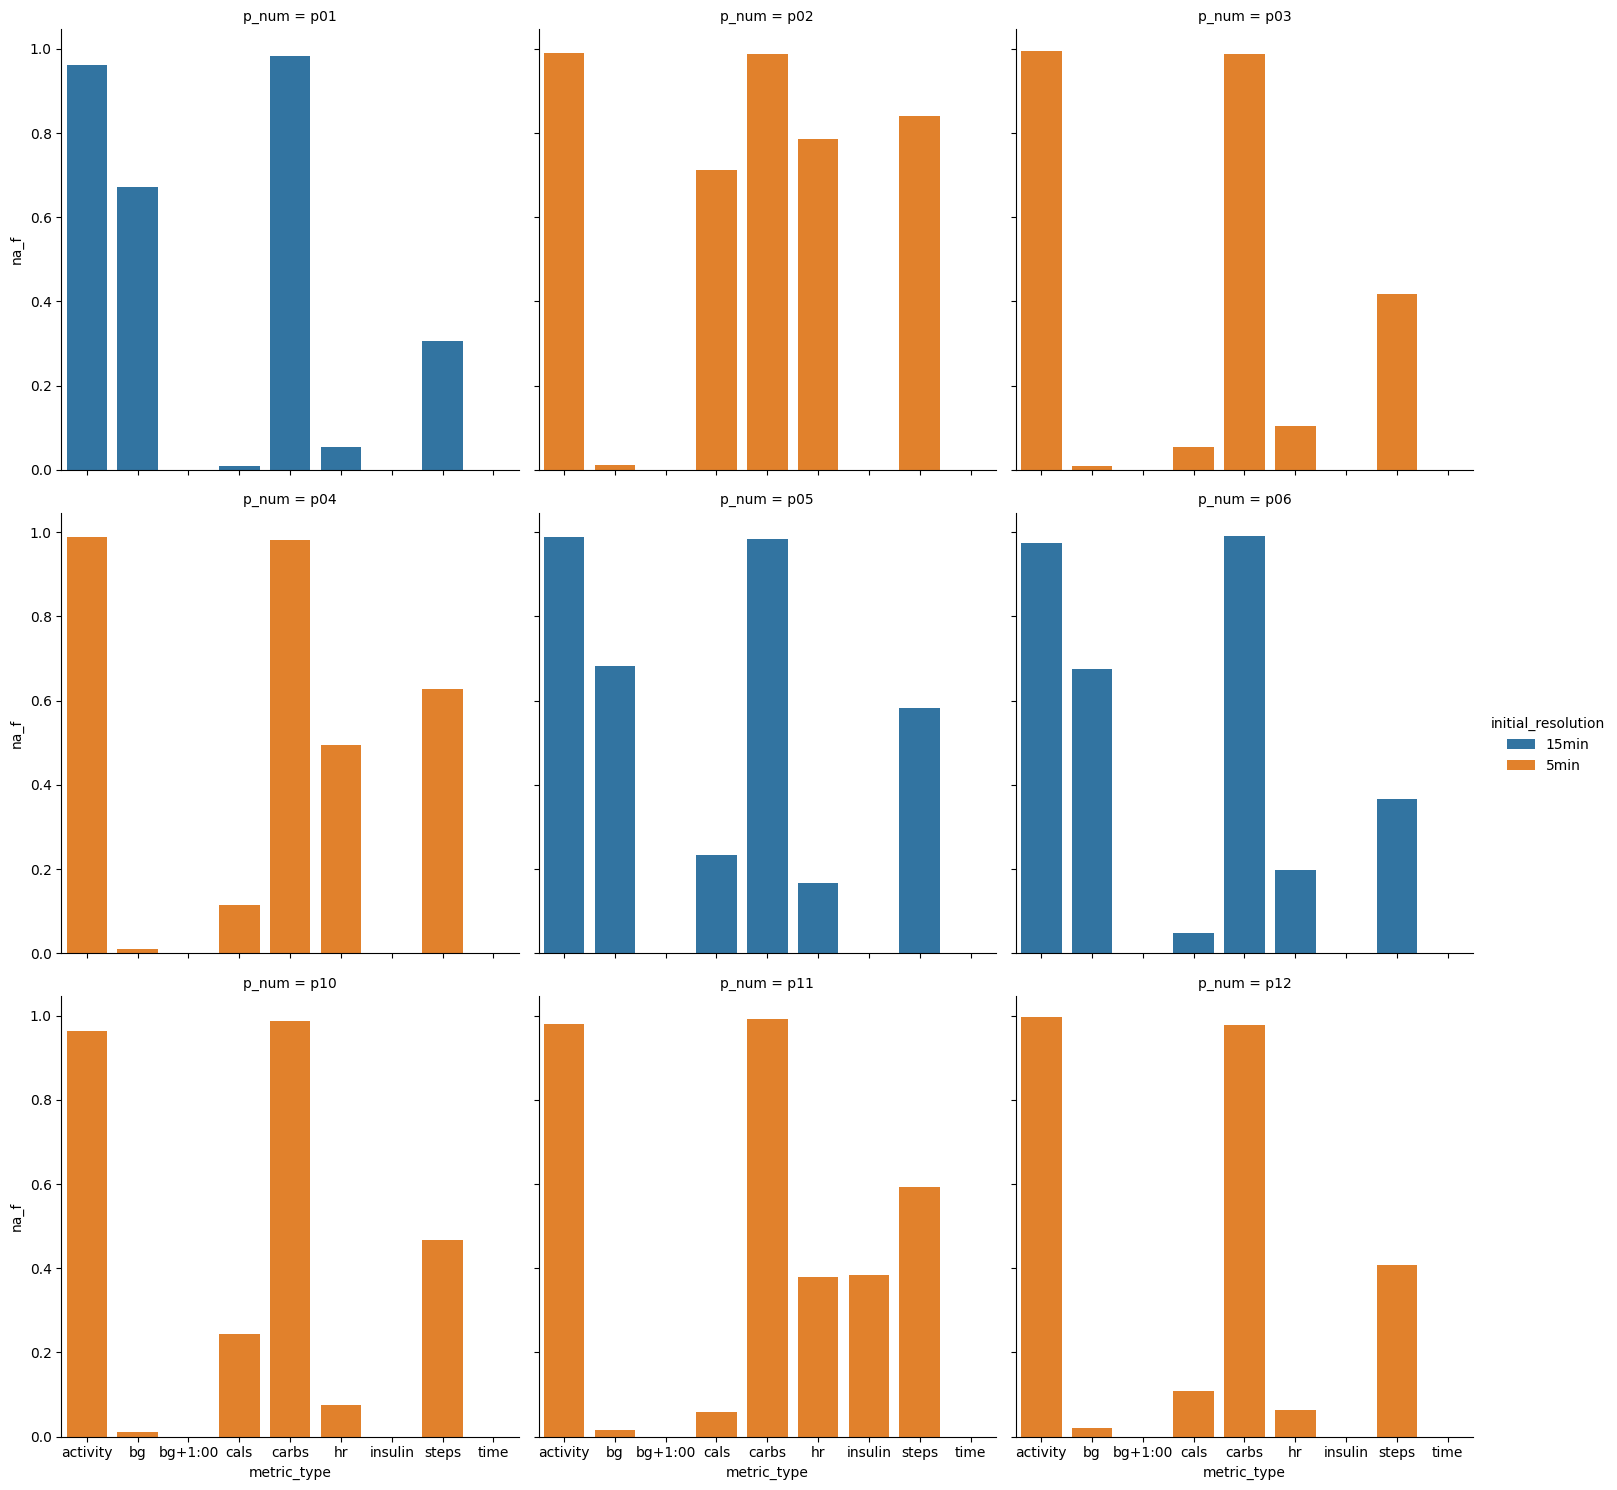

In [29]:
# Plot fraction of NAs per feature per patiend
plt.figure( figsize = (7,7) )
sns.catplot(
    data = res_g, 
    x = 'metric_type', 
    y = 'na_f',
    col = 'p_num' , 
    kind = 'bar' , 
    col_wrap = 3 , 
    hue = 'initial_resolution'
);

<Figure size 1000x1000 with 0 Axes>

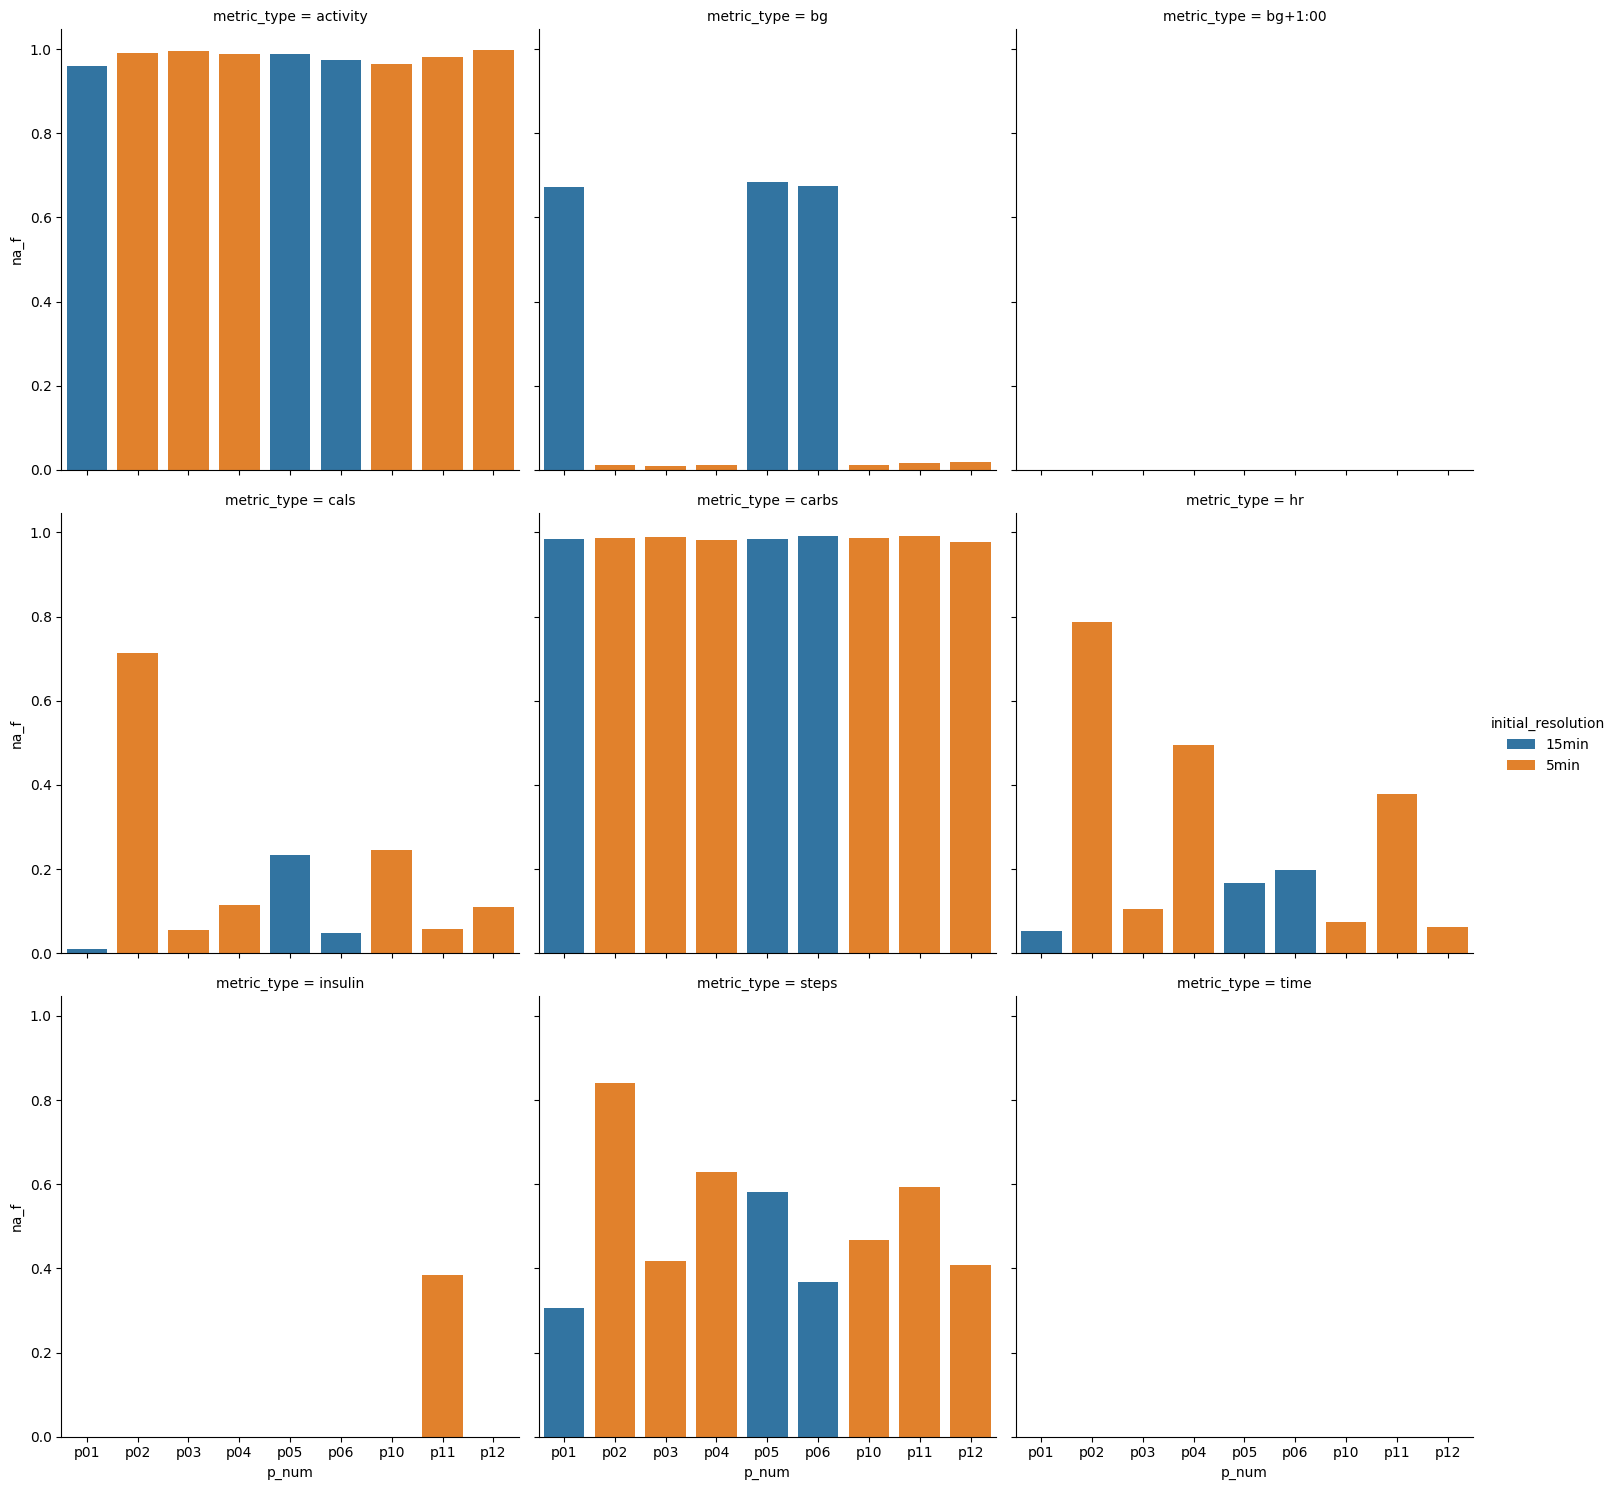

In [18]:
plt.figure( figsize = (10,10) )
sns.catplot(
    data = res_g, 
    x = 'p_num', 
    y = 'na_f',
    col = 'metric_type' , 
    kind = 'bar' , 
    col_wrap = 3 , 
    hue = 'initial_resolution'
)

# Global Time Series Analysis

In [31]:
parse_dates=['date'], index_col='date'
all_train.head()

,p_num,bg,insulin,carbs,hr,steps,cals,activity,bg+1:00,initial_resolution
2020-01-01 00:15:00,p01,NaN,0.0083,NaN,NaN,NaN,NaN,NaN,NaN,15min
2020-01-01 00:20:00,p01,NaN,0.0083,NaN,NaN,NaN,NaN,NaN,NaN,15min
2020-01-01 00:25:00,p01,9.6,0.0083,NaN,NaN,NaN,NaN,NaN,NaN,15min
2020-01-01 00:30:00,p01,NaN,0.0083,NaN,NaN,NaN,NaN,NaN,NaN,15min
2020-01-01 00:35:00,p01,NaN,0.0083,NaN,NaN,NaN,NaN,NaN,NaN,15min


<Figure size 300x300 with 0 Axes>

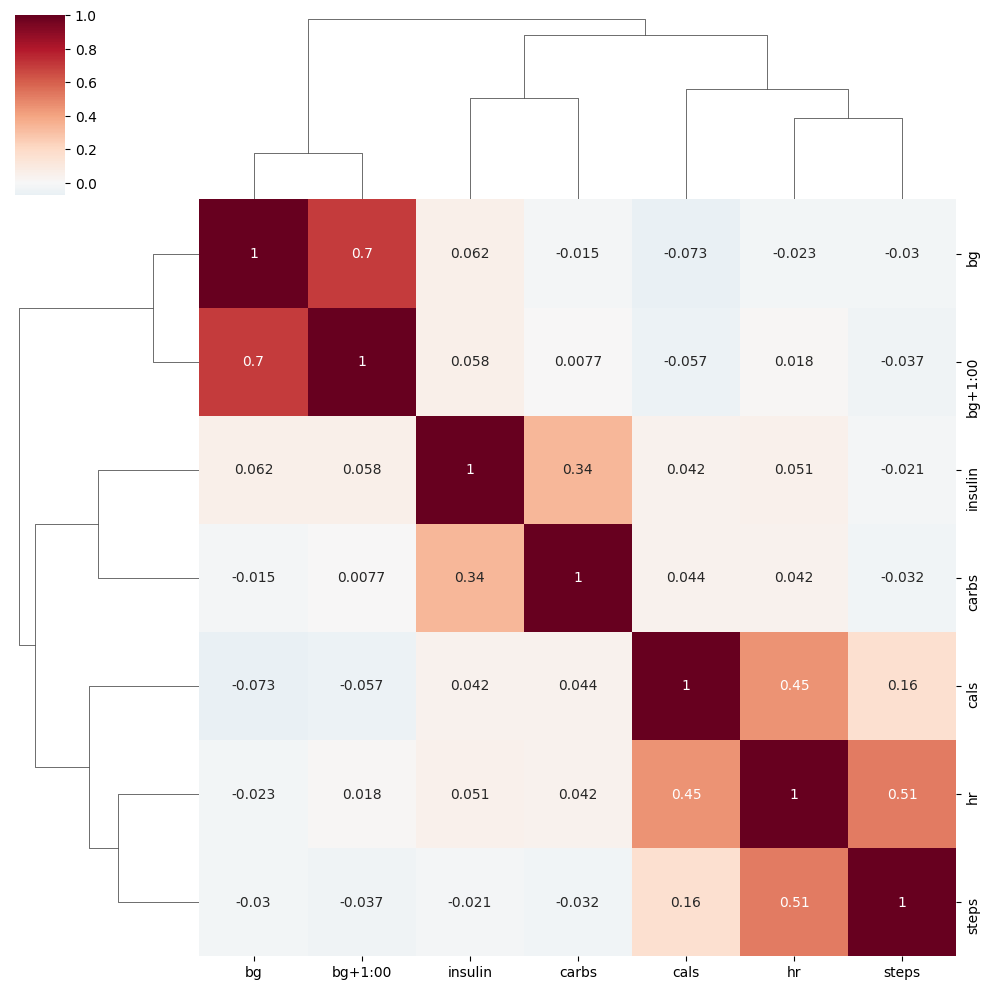

In [67]:
test = all_train[['bg','insulin','carbs','hr','steps','cals','bg+1:00']]
#test =  test - test.mean()

plt.figure( figsize=(3,3) )
sns.clustermap( test.corr() , center = 0 , cmap = "RdBu_r" , annot = True )

In [73]:
test.rolling(window=10).mean()

,bg,insulin,carbs,hr,steps,cals,bg+1:00
2020-01-01 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 00:25:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 00:35:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2020-04-01 23:35:00,8.55,0.3360,NaN,NaN,NaN,6.75,11.37
2020-04-01 23:40:00,8.89,0.4145,NaN,NaN,NaN,6.75,11.36
2020-04-01 23:45:00,9.21,0.4455,NaN,NaN,NaN,6.75,11.27
2020-04-01 23:50:00,9.52,0.4230,NaN,NaN,NaN,6.75,11.18


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


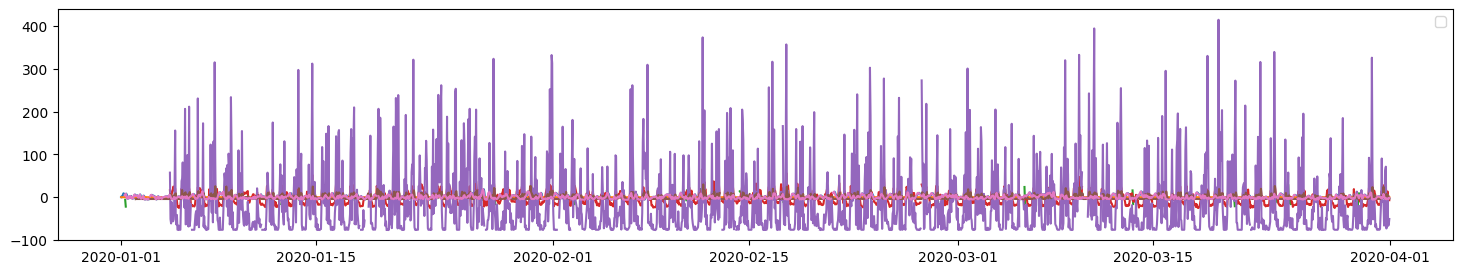

In [62]:
plt.figure( figsize=(18,3) )
plt.plot( test.resample('H').mean() )
plt.legend( loc = 'best' )

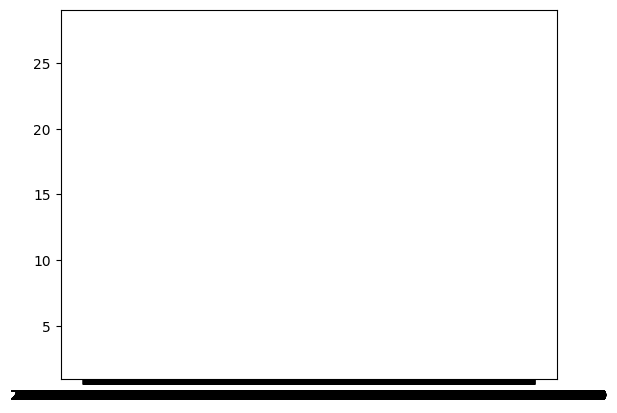

In [33]:
plt.plot(test.bg)

# EDA notes
* plot time series

# Feat engenireeng notes
* Convert time stamp to cols of Hours, minutes 
* SimpleImputzer( strategy = 'mean' ) . Fill NAs in Categorical with 'None' ( str )
* Boruta algorithm for feature selection

# Modelling notes
* in one notebook, the author droped all the activity and carbs columns
* CatBoostRegressor | HistGradientBoostingRegressor , drop cols with >50% NAs
* Light Gradient Boosting 
* LSTMs 
* XGBRegressor
* AutoGluon (an AutoML package developed by AWS )

In [22]:
# Download Leaderboard from kaggle
#!pip install kaggle==1.6.17

os.system('kaggle competitions leaderboard -c brist1d -o')

Traceback (most recent call last):
  File "/Users/masaver/Desktop/masaver/data_science_projects/sep24_bds_int_medical/.venv/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/Users/masaver/Desktop/masaver/data_science_projects/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/Users/masaver/Desktop/masaver/data_science_projects/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/kaggle/api/kaggle_api_extended.py", line 407, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /Users/masaver/.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


256

In [20]:

# Extract table headers
headers = [th.text.strip() for th in table.find_all('th')]

# Extract table rows
rows = []
for row in table.find_all('tr'):
    rows.append([td.text.strip() for td in row.find_all('td')])

AttributeError: 'NoneType' object has no attribute 'find_all'